# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from algorithms import  *

50000.0 51150000.0 512


In [15]:
Nintg=32
data = produce_data(alpha=-0.0, dalpha_dt=-0.00, Nintg=Nintg, add_noise=True)

A=analyze_data(data,tmax=2,Nintg=Nintg, alpha_start=+0.0, force_detect=True)
next(A)
next(A)

50000.0 51150000.0 512
[[1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 ...
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]]
new pdrift =  -8.367503062367153e-05
[[1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 ...
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]
 [1.-0.j 1.-0.j 1.+0.j ... 1.-0.j 1.+0.j 1.+0.j]]


(0.030700000000000005,
 0.0,
 0.0,
 -8.367503062367153e-05,
 39.21858530914122,
 True)

In [216]:
data = produce_data(alpha=-1.2, dalpha_dt=-0.00, Nintg=Nintg, add_noise=True)
A=analyze_data_corr(data,tmax=2,Nintg=Nintg, ofs_start=+0.001, force_detect=True,maxdriftndx=500)
next(A)


401.07080744121214 -0.45521412350717205 0.001 0 sig noise
497.76519777110536 -0.4958600347494807 -0.0005258308928275872 0 sig noise
494.4352769786017 -0.37305286815096517 -0.00036828403083617907 0 sig noise
493.9287576158482 0.8148510295959377 -0.0006091743848022799 0 sig noise
494.190184745195 0.2709876900052176 -0.0008546212068533672 0 sig noise
495.4699746364962 -1.320243314138543 -0.0010957257831728175 0 sig noise
495.3885639285702 1.130832665519241 -0.0013373745548718756 0 sig noise
495.8358571370638 -1.1877073842650487 -0.0015779867737167647 0 sig noise
496.3171606855611 1.3269574288907449 -0.0018206407770191308 0 sig noise
495.7656439711908 0.1261364824001575 -0.0020612488078313213 0 sig noise
495.31081409264857 0.3911776158568643 -0.0022960703152201107 0 sig noise
495.86439655680135 0.7865627103118714 -0.002549271549879142 0 sig noise
495.4412847050126 1.1981163224995177 -0.002782044148844389 0 sig noise
496.0822034555008 -0.0978767992130345 -0.0030259213752686018 0 sig noise
4

(0.040940000000000004,
 1.1999999999999997,
 0.0,
 -0.030772702214342595,
 56.628055043215056,
 128)

In [146]:
data = use_refspec_data('../../refspec/calibrator_review22/notch_03.bin', Nintg=8, add_noise=False, SNR_dB=-10)
ana = analyze_data(data,tmax=30,Nintg=8, alpha_start=0.25, force_detect=True, maxdriftndx=500)

#_,_,_,_,_,_, sum0=next(ana)
#sum  = sum0
#print (sum[2])
#for i in range(2):
##    _,_,_,_,_,_, sum0=next(ana)
##    sum += sum0
#    print (sum[2])



In [147]:
def reorder (x):
    a= []
    for i in range(6):
        a.append(np.array([l[i] for l in x]))
    return a



In [240]:

res=[]

for Nintg in [64]:#, 128, 256]:
    data = produce_data(alpha=+0.3, dalpha_dt=-0.01, sc=15, ssig=3.5, Nintg=Nintg, add_noise=True)
    #data = use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=Nintg, add_noise=True, SNR_dB=-10)
    res.append ( list(analyze_data(data,tmax=30,Nintg=Nintg, alpha_start=-0.3, force_detect=False, maxdriftndx=500))) 
    

In [241]:
resc = []
for Nintg in [64]:#, 128, 256]:
    data = produce_data(alpha=+0.3, dalpha_dt=-0.01, sc=15, ssig=3.5, Nintg=Nintg, add_noise=True)
    resc.append ( list(analyze_data_corr(data,tmax=30,Nintg=Nintg, ofs_start=-0.3, force_detect=False, maxdriftndx=500)))

In [242]:



#sum1 = np.array([x[6] for x in res[0]])


# t, alpha, dB, pdrift/alpha_to_pdrift, SNRdB, detect, sum0

t1, inalpha1, inSNR1, alpha1, SNR1, detect1  = reorder(res[0])
t1c, inalpha1c, inSNR1c, alpha1c, SNR1c, detect1c  = reorder(resc[0])
#t2, inalpha2, inSNR2, alpha2, SNR2, detect2 =res[1].T
#t3, inalpha3, inSNR3, alpha3, SNR3, detect3 =res[2].T
#sum1.shape

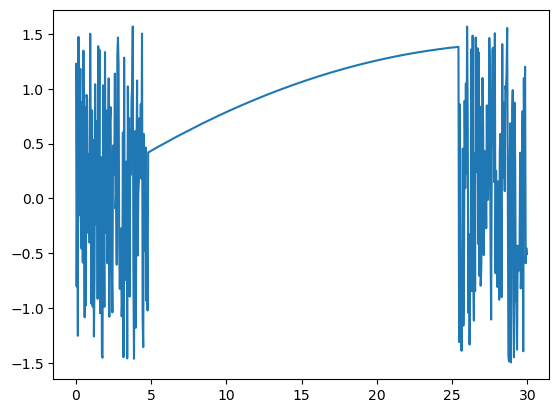

In [243]:
plt.plot(t1c,alpha1c)
#plt.xlim(20,28)

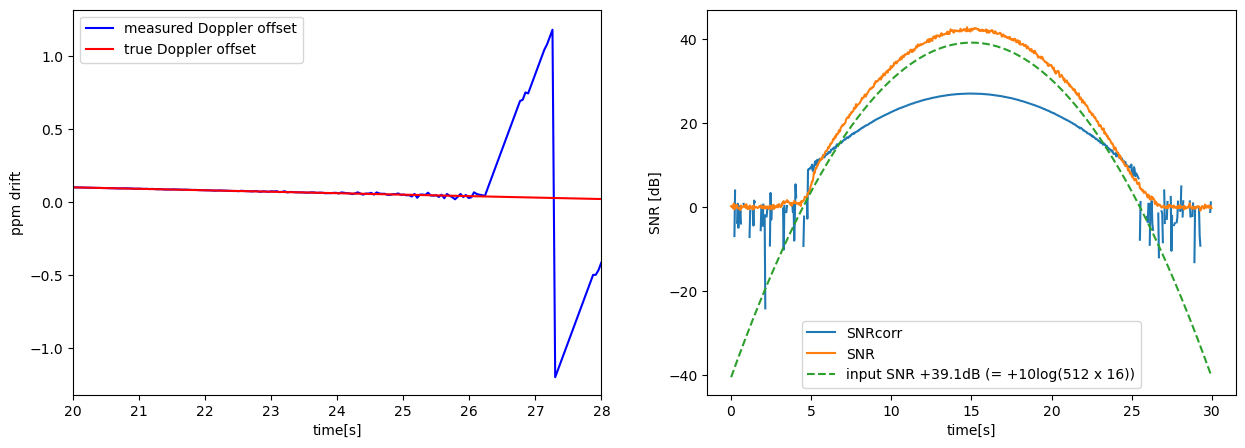

In [244]:

fig=plt.figure(figsize=(15,5))
ax1,ax2 = fig.subplots(nrows=1, ncols=2)
#inalpha1 = 0.3*np.ones_like(t1)
ax1.plot (t1,alpha1,'b-', label='measured Doppler offset')
ax1.plot (t1,-inalpha1,'r-', label='true Doppler offset')
ax1.set_xlabel('time[s]')
ax1.set_ylabel('ppm drift')
ax1.legend()
ax1.set_xlim(20,28)
ax2.plot(t1,SNR1c,label='SNRcorr')
ax2.plot(t1,SNR1,label='SNR')
ax2.plot(t1,inSNR1+39.1,'--',label='input SNR +39.1dB (= +10log(512 x 16))')
ax2.set_xlabel('time[s]')
ax2.set_ylabel('SNR [dB]')
ax2.legend()

#plt.plot(t2,inalpha2,label='real Doppler offset')
#plt.plot (t2,-alpha2,'g-',label='measured Doppler offset')
#plt.plot(t2,detect2, label='detect flag')

#plt.plot(t3,inalpha3)
#plt.plot (t3,-alpha3,'b-')
#plt.plot(t3,detect3)

#plt.legend()
#plt.ylabel('ppm drift')

In [105]:
#Sum in bins of SNR
dSNR = 5
SNRbins = np.arange(1,45,dSNR)
sums = []
for s in SNRbins:
    w = np.where((SNR1>s) & (SNR1<s+dSNR))
    csum = sum1[w,:].sum(axis=1)[0]
    sums.append(csum)
    
#dt=7.5
#tbins = np.arange(0,30,dt)
#sums = []
#for s in tbins:
#    w = np.where((t1>s) & (t1<s+dt))
#    csum = sum1[w,:].sum(axis=1)[0]
#    sums.append(csum)

    
sums = np.array(sums)
#sumsc=sums

In [58]:


def phase_correct (avg):
    p = np.zeros(1025,complex)
    p[1::2] = avg*np.conj(code)
    guess = np.abs(np.fft.fft(p)).argmax()
    if guess>Nb//2:
        guess -= Nb
    rate_in = guess/(2*Nb)
    def fix (rate):
        return avg*np.exp(-1j*2*np.pi*rate*kcomb)
    def penalty (rate):
        pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
        #print (rate,pen)
        return pen
    
    from scipy.optimize import minimize
    bounds = (rate_in-1/256,rate_in+1/256)
    #print (bounds)
    #res = minimize(penalty, rate_in,bounds = [bounds], method='powell')
    search = np.linspace(bounds[0],bounds[-1],10000)
    res = [penalty(x) for x in search]
    res = search[np.argmin(res)]
    print (rate_in, res)
    avgr = fix(res)
    return avgr


0.0869140625 0.08718244871362137
0.0869140625 0.08417199141789179
0.0869140625 0.09025072429117911
0.0869140625 0.08713009972872288
0.0869140625 0.08713244371312132
0.0869140625 0.08712384910366036
0.0869140625 0.08712463043179318
0.0869140625 0.08712463043179318


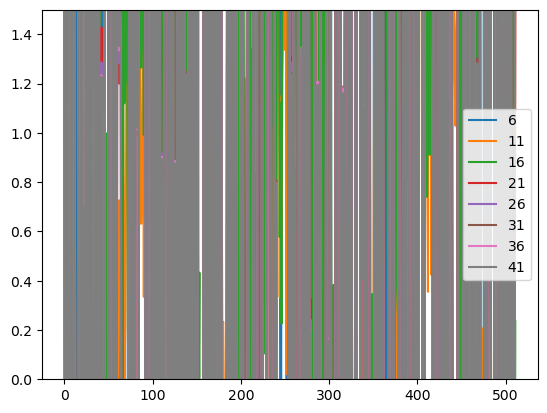

In [59]:


for i,v in enumerate(SNRbins[1:]):
    a = phase_correct(sums[i,:])

#def fix (rate):
#    return x*np.exp(-1j*2*np.pi*rate*kcomb)
#def penalty (rate):
#    pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
    #    return pen
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u/u[:10].mean(),label=str(v))


plt.ylim(0,1.5)

plt.legend()



In [60]:
plt.plot(np.real(sums[5,:]*np.conj(sums[12,:])))
len(sums)

IndexError: index 12 is out of bounds for axis 0 with size 9

In [120]:

res=[]
alpha_out = {32:[]}#, 64:[], 128:[]}
alpha_in = [0]#np.linspace(-1.0,+1.0,100)
alpha_true = 0.0
for Nintg in [32, 64, 128]:
    for alpha_start in alpha_in:
        data = produce_data(alpha=alpha_true,  Nintg=Nintg, sA=0.1, add_noise=False)
        A = analyze_data(data,Nintg=Nintg, alpha_start=alpha_start, force_detect=True)
        next(A)
        alpha_out[Nintg].append(next(A)[3])
for Nintg in [32, 64, 128]:
    alpha_out[Nintg] = np.array(alpha_out[Nintg])   


(1.3012671534890068+2.9234746099890474j) (-226.5692822741513+100.84820439539799j) (-10589.06146151679-23789.77463878589j) sums
-2.9477859625186974e-13 -21823.999999999978 FDSD
new pdrift =  8.571576410142886e-19
(1.3012671534890068+2.9234746099890474j) (-226.5692822741513+100.84820439539799j) (-10589.06146151679-23789.77463878589j) sums
-2.9477859625186974e-13 -21823.999999999978 FDSD
(2.602534306978014+5.846949219978099j) (-920.8945021465505+409.899153349037j) (-86761.9874588795-194922.66962101983j) sums
-7.758328457211567e-13 -349440.00000000047 FDSD


/tmp/ipykernel_1663306/1318891823.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  SNRdB = np.log10(sig2.sum()/noise2.sum())*10


KeyError: 64

0.3737373737373738
0.17171717171717166
0.09090909090909094


Text(0, 0.5, 'output Doppler offset [ppm]')

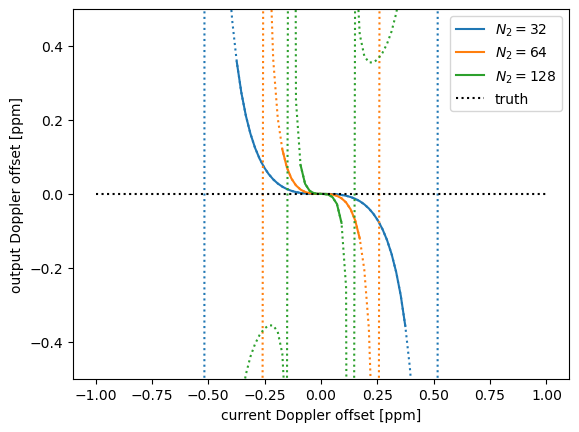

In [116]:
for Nintg in [32,64,128]:
    p=plt.plot(alpha_in, alpha_out[Nintg],':')
    
    w = np.where(np.abs(alpha_out[Nintg]-alpha_true)<np.abs(alpha_in-alpha_true))
    plt.plot(alpha_in[w], alpha_out[Nintg][w],color=p[0].get_color(),label=f'$N_2={Nintg}$')
    print ((alpha_in[w].max()-alpha_in[w].min())/2)

plt.plot(alpha_in, alpha_true*np.ones_like(alpha_in),'k:', label='truth')
plt.ylim(-0.5,0.5)
plt.legend()
plt.xlabel('current Doppler offset [ppm]')
plt.ylabel('output Doppler offset [ppm]')

In [ ]:
Nintg = 32
res=[]
alpha_var = {32:[], 64:[], 128:[]}
dblist = np.linspace(-60,0,50)
alpha_true = 0.0
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    for Nintg in alpha_var.keys():
        data = produce_data(alpha=0,  Nintg=Nintg, sA=snr, add_noise=True)
        res = []
        for i in range(10): 
            res0 = np.array(list(analyze_data(data,Nintg=Nintg, alpha_start=0, countmax = 12,  force_detect=True)))[5:,3]
            res = np.hstack((res,res0))
        alpha_var[Nintg].append(np.sqrt(res.var()))


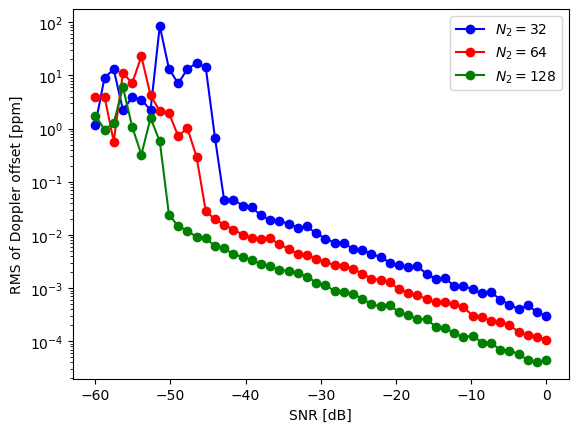

In [ ]:
plt.semilogy()
plt.plot(dblist, np.array(alpha_var[32]),'bo-', label='$N_2=32$')
plt.plot(dblist, alpha_var[64],'ro-', label='$N_2=64$')
plt.plot(dblist, alpha_var[128],'go-', label='$N_2=128$')
plt.xlabel('SNR [dB]')
plt.ylabel('RMS of Doppler offset [ppm]')
plt.legend()

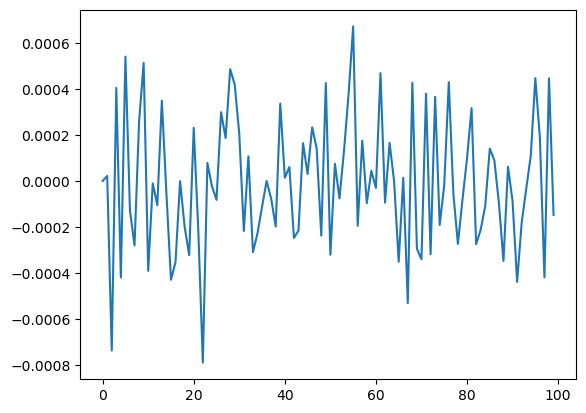

In [ ]:
plt.plot(res[:,3])

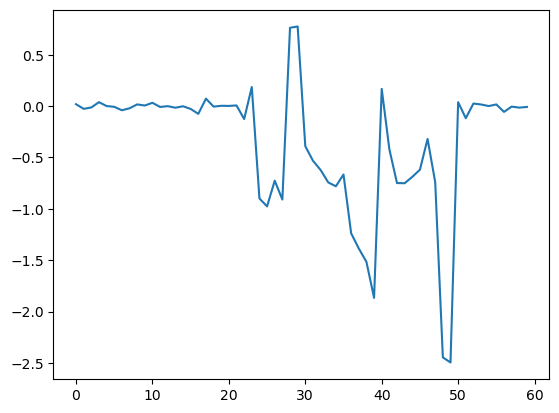

In [ ]:
plt.plot(res)

In [ ]:
data1 = next(use_refspec_data('../../refspec/calibrator_review22/03notch.bin', Nintg=1024))[3]
data2 = next(use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=1024+20))[3][20:,:]
data3 = data1-data2

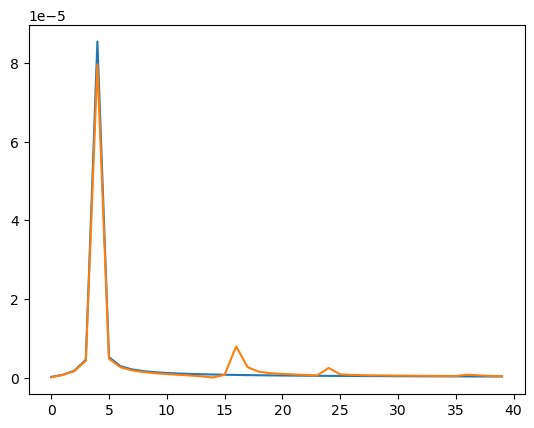

In [ ]:
plt.plot(np.abs(np.fft.rfft(data1[:,200])[:40]))
plt.plot(np.abs(np.fft.rfft(data2[:,200])[:40]))

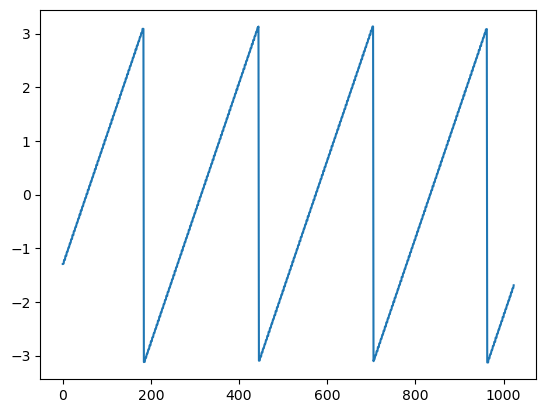

In [ ]:
rez=[]
alpha_rms=[]
dblist = np.linspace(-60,0,10)
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    Nintg=128
    data = produce_data(alpha=+0.3,  Nintg=Nintg, sA=snr, add_noise=True)
    res = list(analyze_data(data,Nintg=Nintg, alpha_start=0.3, countmax = 12,  force_detect=True))
    rez.append(np.array([r[-1] for r in res]))
    alpha_rms.append(np.sqrt(np.array([r[3] for r in res]).var()))




-0.1845703125 -0.18172666876062607
0.0 9.415004000400042e-05
0.0 1.5235898589859367e-05
0.0 -1.0547929792979228e-05
0.0 -7.422617261726092e-06
0.0 5.859960996099957e-06
0.0 7.422617261726092e-06
0.0 4.297304730472955e-06
0.0 5.078632863286456e-06
0.0 5.078632863286456e-06


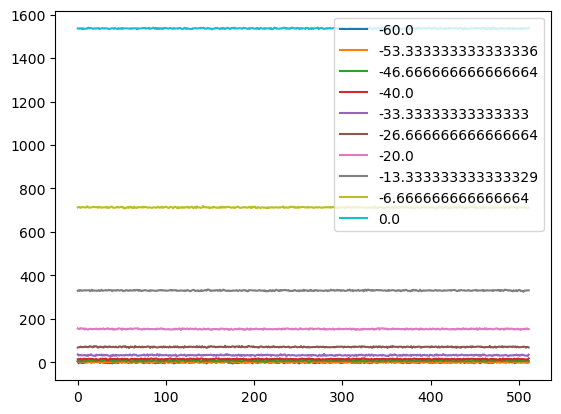

In [ ]:
for rx,v in list(zip(rez,dblist)):
    a = phase_correct(rx.sum(axis=0))
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u,label=str(v))


#plt.ylim(0,1.5)

plt.legend()


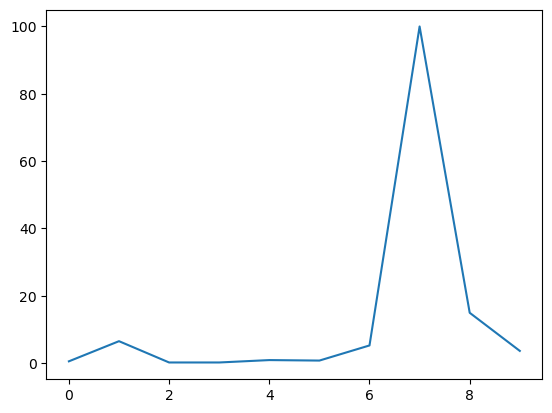

In [ ]:
plt.plot(alpha_rms)

In [158]:
kar=np.arange(32)
(kar**2).sum(),(kar).sum()**2

(10416, 246016)

In [92]:
snrf = lambda ofs: np.real(np.exp(-1j*kcomb[90:500]*ofs)).sum()
snrf(0)

410.0

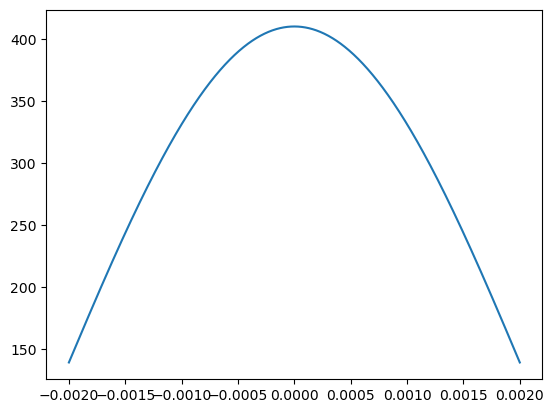

In [95]:
xar = np.linspace(-2e-3,2e-3,1000)
plt.plot(xar,[snrf(x) for x in xar ])
#plt.semilogy()

In [96]:
np.pi/2/2e-3

785.3981633974482

512